In [1]:
import sumie
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import skimage

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
model = torchvision.models.vgg16(pretrained=True).eval()
sumie.utils.remove_inplace(model)
#sumie.utils.max_to_avg_pool(model)
#model.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
def normalise(image):
    
        mean = torch.as_tensor([0.485, 0.456, 0.406])
        std = torch.as_tensor([0.229, 0.224, 0.225])
        return (image - mean[None,:,None,None]) /std[None,:,None,None]
 
class Direction():
    
    def __init__(self, module, target):
        self.monitor = sumie.objectives.ModuleMonitor(module)
        self.target = target.detach()
        
    @property
    def objective(self):
        if self.monitor.values is not None:
            return direction_func(torch.mean(self.monitor.values, (2, 3)).squeeze(0), 
                                  torch.mean(self.target, (2, 3)).squeeze(0))

    
def direction_func(x, y):
    cossim_pow = 2
    eps = 1e-4
    xy_dot = torch.dot(x, y)
    x_mag = torch.sqrt(torch.dot(x, x))
    y_mag = torch.sqrt(torch.dot(y, y))
    cossims = xy_dot / (eps + x_mag) / (eps + y_mag)
    #floored_cossims = torch.max(torch.Tensor((0.1,)), cossims)
    return torch.mean(xy_dot * cossims**cossim_pow)

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Piper_betle_plant.jpg/320px-Piper_betle_plant.jpg'
imsize = 128

device = 'cuda'
model.to(device)
base_image = sumie.io.load_url(url, size=(imsize, imsize))
base_image = normalise(base_image)
monitor = sumie.objectives.ModuleMonitor(model.features[26])
model.features(base_image.to(device))
target = monitor.values

im = sumie.Image(imsize, param='fft', transforms=[
                    sumie.transforms.PositionJitter(8),
                    sumie.transforms.ScaleJitter(1.01),
                    sumie.transforms.Normalise(),
              ])

im.to(device)

content = Direction(model.features[26], target.detach())

opt = sumie.Optimiser(im, model.features, content)
opt.run(iterations=1024, lr=0.05, progress=True)
#opt.run(iterations=100, lr=0.005, progress=True)
sumie.vis.show(im.get_image(), figsize = (10, 10))

 47%|████▋     | 486/1024 [00:14<00:15, 34.58it/s]

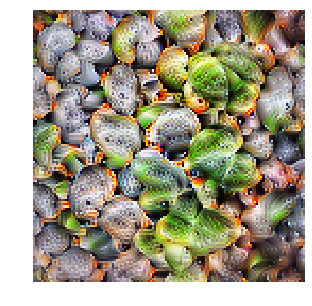

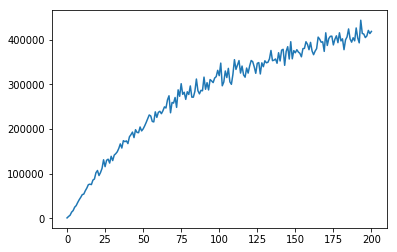

In [9]:
sumie.vis.show(im.get_image())
plt.plot([x.item() for x in opt.history])